<a href="https://colab.research.google.com/github/ivy-Ruxin-Tong/Churn__Prediction/blob/main/Churn_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Summary


Name : Ivy_Tong 
* Objective : to predict whether a customer will leave his or her current telecommunications provider, something known as "customer churning"

* Dataset 

  *   train.csv (4250 rows and 20 columns(19 features and 1 label column)
  *   test.csv (750 lines with 20 columns(19 features and 1 index column)
  *   Kaggle website: https://www.kaggle.com/c/customer-churn-prediction-2020/data


* Model and Conclusion:

  * We have imbalanced label. There are various techniques to handle such an issue. Here, I changed performance evaluation metrics from accuracy_score to average_precision_score(relatively conservative summary of the Precision-Recall curve) and penalized algorithms

    * Xgboost model gives the best ap score of 86% and accuracy score of 96% 
    * Random Forest comes the second with 83% ap score and accuracy score of 94%
    * KNN and SVM model do not perform well
  * Top 3 most important feature are the international_plan_no, number_customer_service_calls, and total_day_minutes



#Analysis

#### Import libraries and Download datasets from Kaggle





In [ ]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


plt.style.use('seaborn-whitegrid')
pd.set_option('display.float_format', lambda x : '%0.3f' %x)
%matplotlib inline

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OneHotEncoder, StandardScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer

In [3]:
%cd /content/

from google.colab import files
files.upload()

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!chmod 600 /content/kaggle.json 

In [ ]:
!kaggle competitions download -c customer-churn-prediction-2020

  0% 0.00/383k [00:00<?, ?B/s]
100% 383k/383k [00:00<00:00, 52.4MB/s]
  0% 0.00/68.4k [00:00<?, ?B/s]
100% 68.4k/68.4k [00:00<00:00, 60.0MB/s]
  0% 0.00/6.04k [00:00<?, ?B/s]
100% 6.04k/6.04k [00:00<00:00, 6.00MB/s]


####  Load Dataset





In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


#### Exploratory Data Analysis

  1.   Basic Info/Statistics








In [ ]:
train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.600,123,27.470,195.500,103,16.620,254.400,103,11.450,13.700,3,3.700,1,no
1,NJ,137,area_code_415,no,no,0,243.400,114,41.380,121.200,110,10.300,162.600,104,7.320,12.200,5,3.290,0,no
2,OH,84,area_code_408,yes,no,0,299.400,71,50.900,61.900,88,5.260,196.900,89,8.860,6.600,7,1.780,2,no
3,OK,75,area_code_415,yes,no,0,166.700,113,28.340,148.300,122,12.610,186.900,121,8.410,10.100,3,2.730,3,no
4,MA,121,area_code_510,no,yes,24,218.200,88,37.090,348.500,108,29.620,212.600,118,9.570,7.500,7,2.030,3,no


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [ ]:
# no missing value
total_missing = train.isna().sum().sort_values(ascending = False)
percent_missing = (train.isna().sum()/train.isna().count()).sort_values(ascending=False)
missing_train = pd.concat([total_missing, percent_missing], axis=1, keys=['Count', 'Percent'])
missing_train

,Count,Percent
churn,0,0.000
number_customer_service_calls,0,0.000
account_length,0,0.000
area_code,0,0.000
international_plan,0,0.000
voice_mail_plan,0,0.000
number_vmail_messages,0,0.000
total_day_minutes,0,0.000
total_day_calls,0,0.000
total_day_charge,0,0.000


In [ ]:
test.isna().sum().sort_values(ascending = False)

number_customer_service_calls    0
total_intl_charge                0
state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
id                               0
dtype: int64

In [ ]:
print(train.duplicated().sum())
print(test.duplicated().sum())

0
0




2.  Visualization - individual variable
     *   14% of customers churned. It will be good if we know the time period being measured here. 14% annual churn rate is within reasonable range for the telecom industry. Response variable is not balanced
     *   91% of all customers does not have international plan
     *   74% of all customers does not have voice mail plan
     *   50% of all customers are in area code 415, and the rest splits between area code 408 and 510
     *   We have customers in all 50 states and DC
     *   Top 3 states by customers are WV (3.27%), MN(2.54%), and ID(2.50%) 
     *   Most of features are normally distributed except total_int_calls, number_customer_service_calls, and number of voicemail messages(right-skewed). Most of customers has single digit number of voicemail messages









In [ ]:
train['churn'].value_counts()

no     3652
yes     598
Name: churn, dtype: int64

In [ ]:
100* train.churn[train.churn=="yes"].count() / train.churn.count()

14.070588235294117

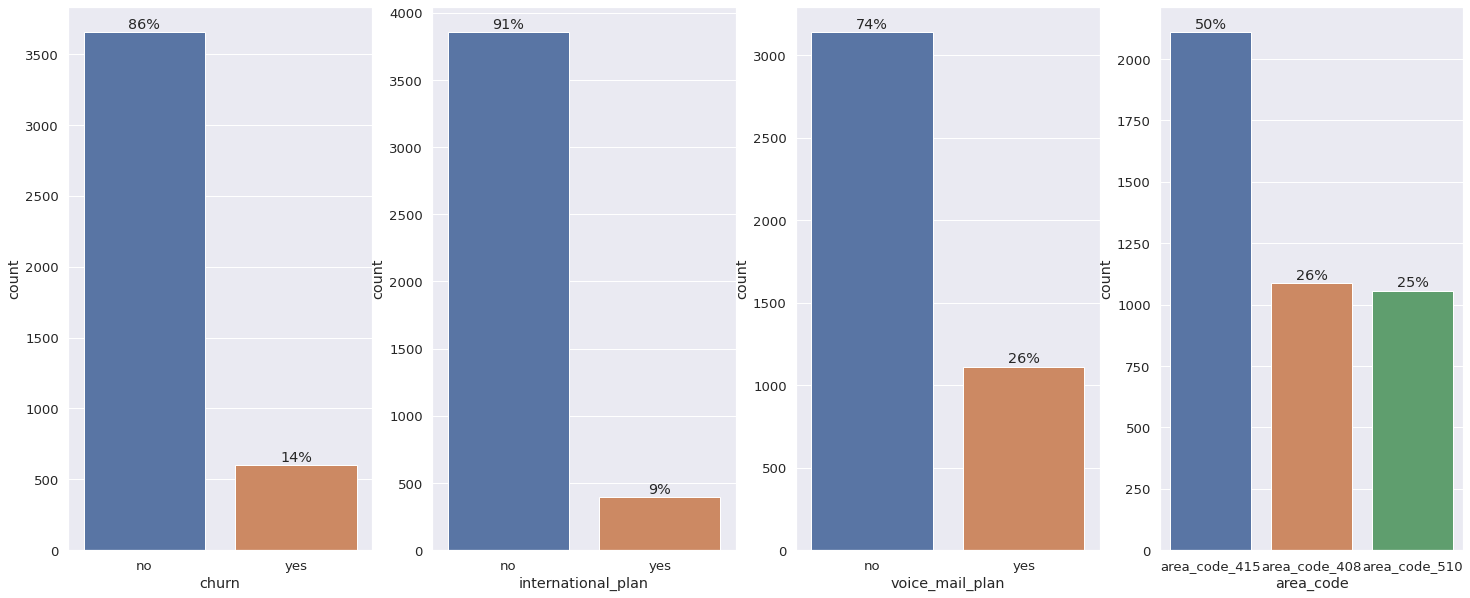

In [ ]:
# Basic Visualization to understand data/each variable
object_col =train.select_dtypes("object")
sns.set(font_scale=1.2)

fig, ax = plt.subplots(1,4, figsize=(25,10))

for i, variable in enumerate(["churn","international_plan","voice_mail_plan","area_code"]):
  sns.countplot(x=variable, data=object_col, order = object_col[variable].value_counts().index, ax = ax[i])
  total  = len(object_col[variable])
  for p in ax[i].patches:
    percentage = f'{100 * p.get_height() / total:.0f}%\n'
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax[i].annotate(percentage, (x, y), ha='center', va='center')

In [ ]:
print(object_col['state'].nunique(),"unique state, and they are: ")
object_col['state'].unique()

51 unique state, and they are: 


array(['OH', 'NJ', 'OK', 'MA', 'MO', 'LA', 'WV', 'IN', 'RI', 'IA', 'MT',
       'NY', 'ID', 'VA', 'TX', 'FL', 'CO', 'AZ', 'SC', 'WY', 'HI', 'NH',
       'AK', 'GA', 'MD', 'AR', 'WI', 'OR', 'MI', 'DE', 'UT', 'CA', 'SD',
       'NC', 'WA', 'MN', 'NM', 'NV', 'DC', 'VT', 'KY', 'ME', 'MS', 'AL',
       'NE', 'KS', 'TN', 'IL', 'PA', 'CT', 'ND'], dtype=object)

In [ ]:
object_col['state'].value_counts()
# object_col['state'].value_counts(normalize=True) # calculate %

WV    139
MN    108
ID    106
AL    101
VA    100
OR     99
TX     98
UT     97
NJ     96
NY     96
WY     95
OH     95
WI     94
ME     89
MA     89
CT     88
KS     87
MI     87
RI     87
VT     86
MD     86
KY     85
NV     83
IN     83
MS     82
MT     80
MO     80
DE     80
CO     80
NC     80
WA     80
IL     79
TN     79
NH     78
OK     78
NM     78
AZ     77
HI     77
FL     76
SD     75
NE     73
DC     72
SC     72
AR     71
LA     69
PA     67
ND     67
GA     64
IA     62
AK     61
CA     39
Name: state, dtype: int64

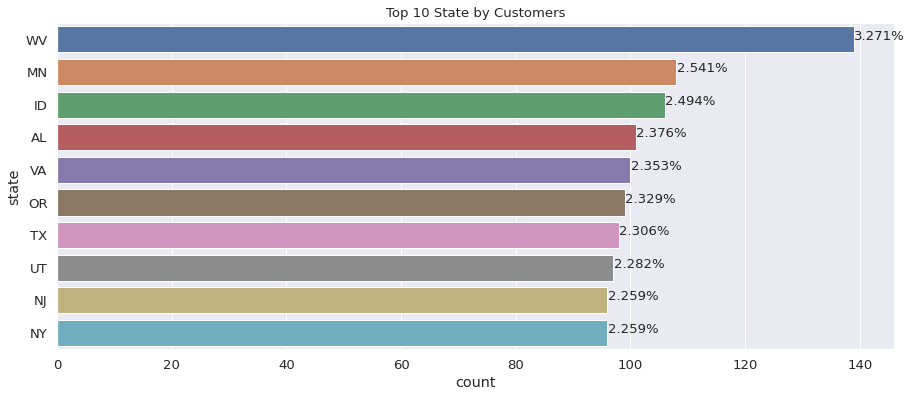

In [ ]:
ax = sns.countplot(y='state', data=object_col,order = object_col['state'].value_counts()[:10].index)
total = len(object_col['state'])
sns.set(font_scale=1.1)

for p in ax.patches:
        percentage = '{0:.3f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.05
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.title('Top 10 State by Customers')
fig = plt.gcf()
fig.set_size_inches(15, 6)
plt.show()


In [ ]:
numerical_col = train.select_dtypes(["float64", "int64"]).columns
train.select_dtypes(["float64", "int64"]).describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,4250.000,4250.000,4250.000,4250.000,4250.000,4250.000,4250.000,4250.000,4250.000,4250.000,4250.000,4250.000,4250.000,4250.000,4250.000
mean,100.236,7.632,180.260,99.907,30.645,200.174,100.176,17.015,200.528,99.840,9.024,10.256,4.426,2.770,1.559
std,39.698,13.440,54.012,19.851,9.182,50.250,19.909,4.271,50.354,20.093,2.266,2.760,2.463,0.745,1.311
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,73.000,0.000,143.325,87.000,24.365,165.925,87.000,14.102,167.225,86.000,7.522,8.500,3.000,2.300,1.000
50%,100.000,0.000,180.450,100.000,30.680,200.700,100.000,17.060,200.450,100.000,9.020,10.300,4.000,2.780,1.000
75%,127.000,16.000,216.200,113.000,36.750,233.775,114.000,19.867,234.700,113.000,10.560,12.000,6.000,3.240,2.000
max,243.000,52.000,351.500,165.000,59.760,359.300,170.000,30.540,395.000,175.000,17.770,20.000,20.000,5.400,9.000


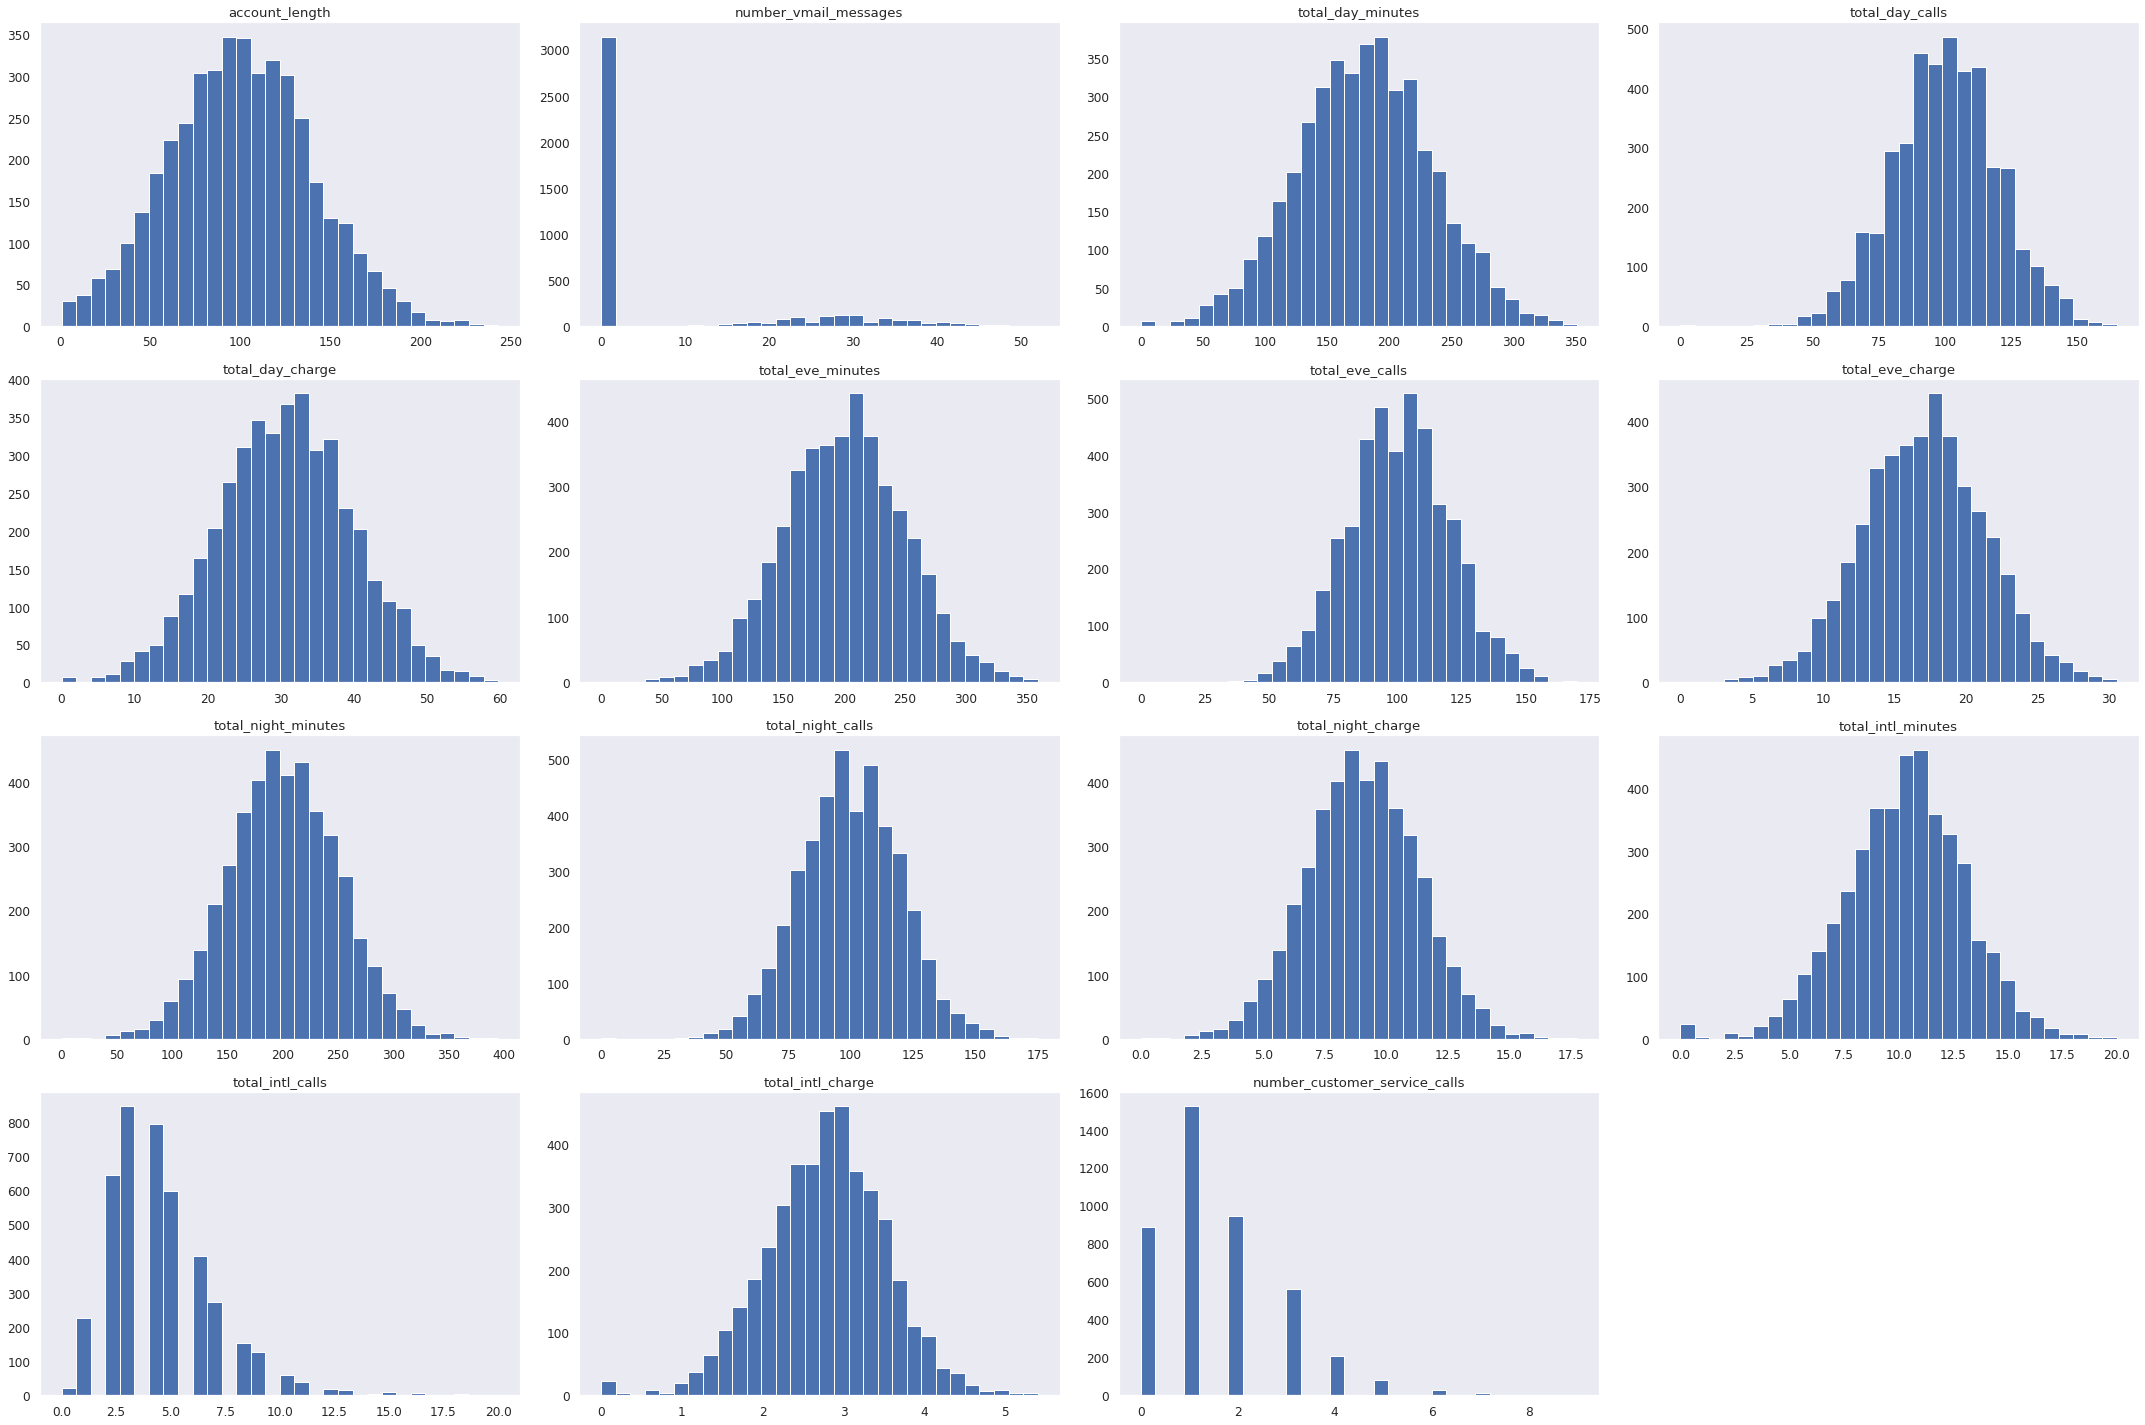

In [ ]:
train.hist(bins=30,figsize=(30,20),grid=False)
plt.tight_layout()
plt.show()




3.   Visualization : Relationship between churn and features


  *   There is a higher percent of attrited customers have international plan (28% v.s. 6% for existing customers)
  *   There's a higher percent of existing customers have voice mail plan (28% v.s. 14% for attrited customers)

  *   Area codes distribution are similar for both customer groups
  *   NJ has the higest churn rate of 4.3%
  *   Associated call minutes and charges exhibit exact behavior, comfirmed by the perfect correlation coefficient of 1
  *   Features such as number_customer_service_calls (attrited customers tend to have a higher number of customer service calls), total_day_minutes(attrited customers tend to have a higher number of total_day_minutes) have difference behaviors for churned customers








In [ ]:
for i in ['international_plan','voice_mail_plan','area_code']:
  i = pd.crosstab(index=train[i], 
                            columns=train["churn"] ) 
  i = i.div(i.sum(axis = 0), axis = 1).round(2)

  display(i)
  print("\n\n")

churn,no,yes
international_plan,,
no,0.940,0.720
yes,0.060,0.280


churn,no,yes
voice_mail_plan,,
no,0.720,0.860
yes,0.280,0.140


churn,no,yes
area_code,,
area_code_408,0.260,0.250
area_code_415,0.500,0.480
area_code_510,0.250,0.270


total_day_minutes
total_day_charge
total_eve_minutes
total_eve_charge
total_night_minutes
total_night_charge
total_intl_minutes
total_intl_charge


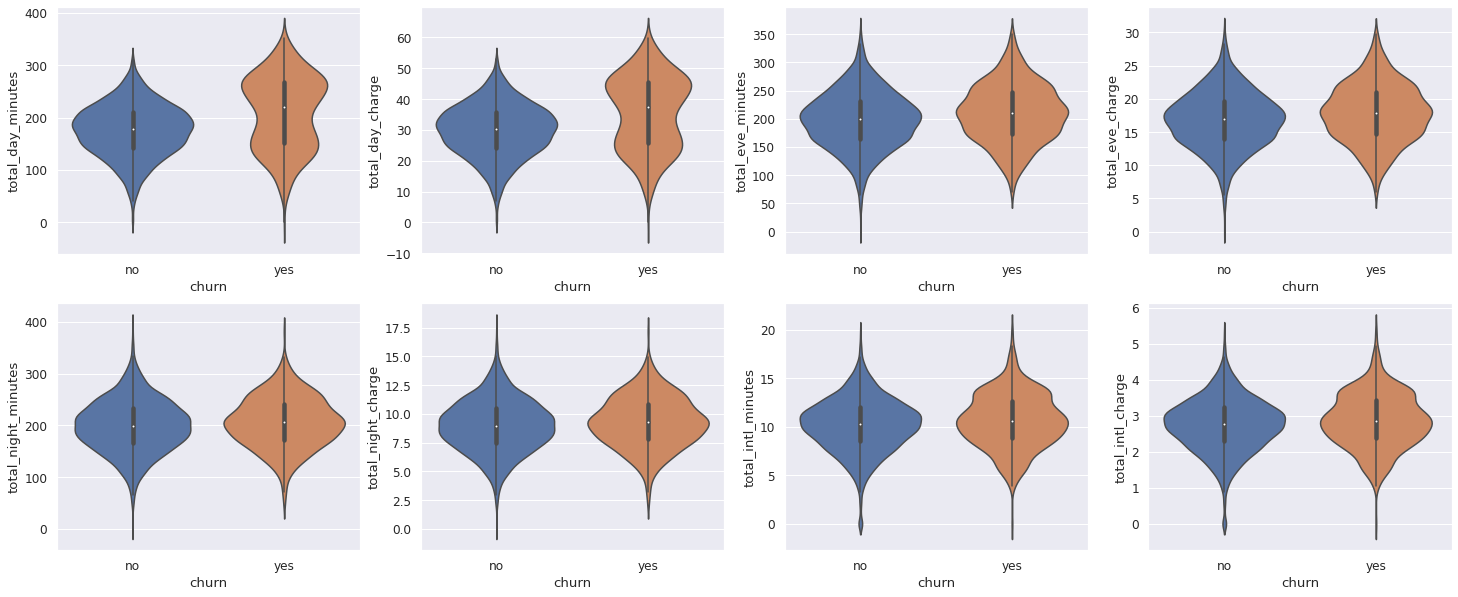

In [ ]:
fig, ax = plt.subplots(2,4,figsize=(25,10))

for i,variable in enumerate(train.select_dtypes(["float64"]).columns):
  print(variable)
  sns.violinplot(
      x='churn',   
      y=variable,
      data=train, ax= ax[math.floor(i/4)][i%4])
    

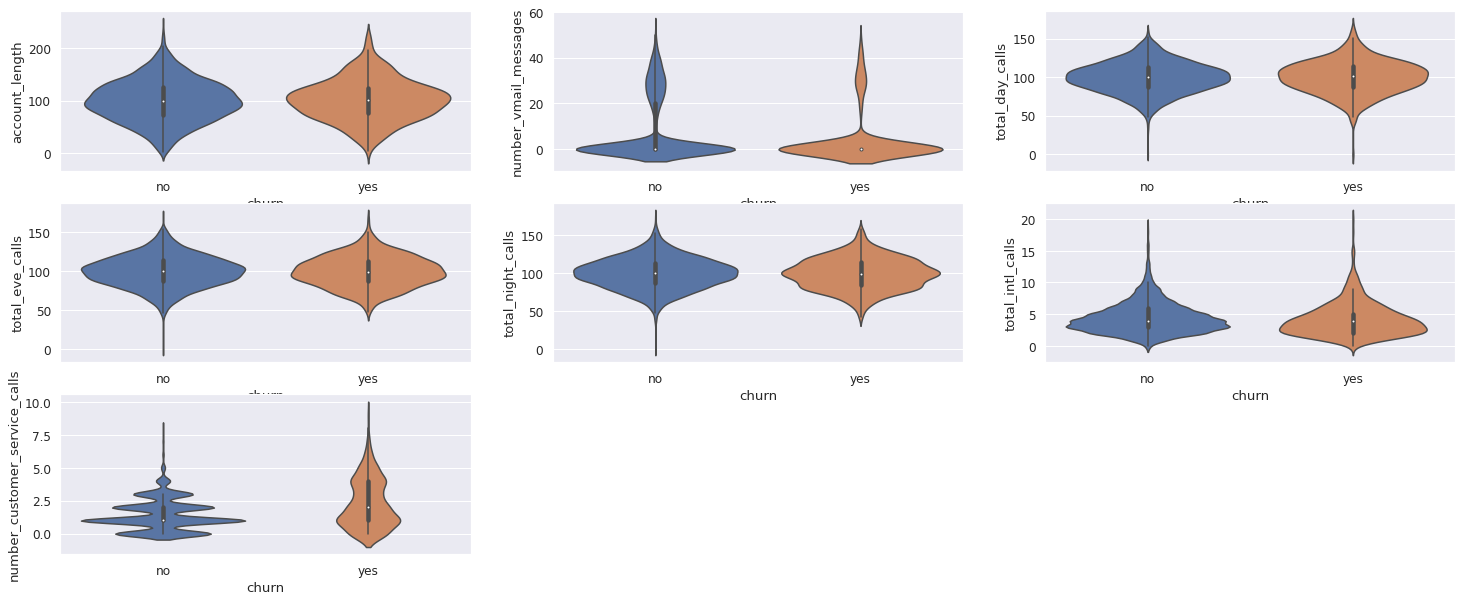

In [ ]:
plt.figure(figsize=(25,10))

for i, variable in enumerate(train.select_dtypes(["int"]).columns):
   plt.subplot(3,3,i+1)
   sns.violinplot(
    x='churn',   
    y=variable,
    data=train)

Correlation Matrix : 


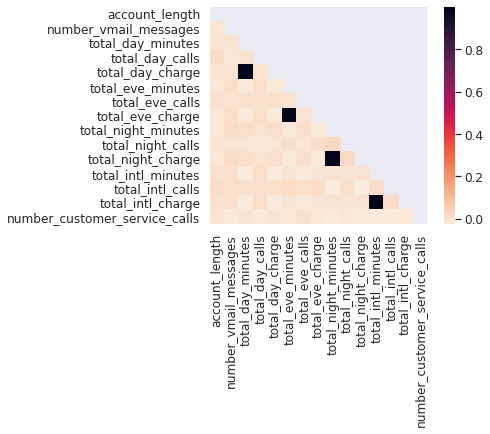

In [ ]:
# correlation matrix
corr = train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,0)] = True
print('Correlation Matrix : ')
sns.heatmap(corr, mask = mask,square = True, annot = False, cmap="rocket_r")

In [ ]:
train['churn'] = train['churn'].apply(lambda x: 0 if x == 'no' else 1)

In [ ]:
(train.groupby('state')['churn'].sum()/train['churn'].sum()).sort_values(ascending = False).head()

state
NJ   0.043
MN   0.032
MD   0.032
WV   0.032
TX   0.032
Name: churn, dtype: float64



#### Scaling and Encoding




In [ ]:
# charges variables are perfectly correlated with the minutes, so i droped them
test = test.drop(['id','total_day_charge','total_eve_charge','total_night_charge','total_intl_charge'], axis=1)
test

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls
0,KS,128,area_code_415,no,yes,25,265.100,110,197.400,99,244.700,91,10.000,3,1
1,AL,118,area_code_510,yes,no,0,223.400,98,220.600,101,203.900,118,6.300,6,0
2,IA,62,area_code_415,no,no,0,120.700,70,307.200,76,203.000,99,13.100,6,4
3,VT,93,area_code_510,no,no,0,190.700,114,218.200,111,129.600,121,8.100,3,3
4,NE,174,area_code_415,no,no,0,124.300,76,277.100,112,250.700,115,15.500,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,GA,130,area_code_415,no,no,0,119.400,99,226.300,97,202.700,111,11.300,7,0
746,WA,73,area_code_408,no,no,0,177.200,118,270.500,84,241.800,112,12.300,2,3
747,WV,152,area_code_415,no,no,0,184.200,90,256.800,73,213.600,113,14.700,2,3
748,DC,61,area_code_415,no,no,0,140.600,89,172.800,128,212.400,97,13.600,4,1


In [ ]:
train_1 = train.copy()
features = train_1.drop(['churn', 'total_day_charge','total_eve_charge','total_night_charge','total_intl_charge'], axis=1)
features.info()

label = train_1['churn']
label

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_eve_minutes              4250 non-null   float64
 9   total_eve_calls                4250 non-null   int64  
 10  total_night_minutes            4250 non-null   float64
 11  total_night_calls              4250 non-null   int64  
 12  total_intl_minutes             4250 non-null   f

0       0
1       0
2       0
3       0
4       0
       ..
4245    0
4246    0
4247    0
4248    0
4249    0
Name: churn, Length: 4250, dtype: int64

In [ ]:
# minmaxscalar numerical values
mm_scaler = MinMaxScaler()
numerical_col =features.select_dtypes(["float64", "int64"]).columns

mm_scale = mm_scaler.fit(train.drop('churn', axis = 1)[numerical_col])
features[numerical_col] = mm_scale.transform(features[numerical_col])

mm_scale_test = mm_scaler.fit(test[numerical_col])
test[numerical_col] = mm_scale_test.transform(test[numerical_col])


In [ ]:
def dummy_conversion(data):
    return pd.get_dummies(data)

features = dummy_conversion(features)
test = dummy_conversion(test)

#one hot encoding, columns transformer could not produce the column names, would be inconvenient for later feature importance
# enc = OneHotEncoder(handle_unknown = 'ignore',sparse = False)
# ct = ColumnTransformer([("enc",enc,train.select_dtypes(["object"]).columns)], remainder = 'passthrough')
# features = ct.fit_transform(features)
# test = ct.fit_transform(test)

# features


In [ ]:
features

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes
0,0.438,0.500,0.460,0.745,0.544,0.606,0.644,0.589,0.685,0.150,0.111,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
1,0.562,0.000,0.692,0.691,0.337,0.647,0.412,0.594,0.610,0.250,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
2,0.343,0.000,0.852,0.430,0.172,0.518,0.498,0.509,0.330,0.350,0.222,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0
3,0.306,0.000,0.474,0.685,0.413,0.718,0.473,0.691,0.505,0.150,0.333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
4,0.496,0.462,0.621,0.533,0.970,0.635,0.538,0.674,0.375,0.350,0.333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,0.339,0.000,0.536,0.424,0.679,0.518,0.541,0.451,0.515,0.300,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
4246,0.298,0.000,0.506,0.539,0.365,0.482,0.471,0.509,0.575,0.300,0.333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0
4247,0.306,0.000,0.486,0.612,0.537,0.741,0.327,0.594,0.345,0.350,0.111,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
4248,0.202,0.769,0.671,0.770,0.621,0.741,0.753,0.663,0.495,0.250,0.222,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1


In [ ]:
features.shape

(4250, 69)

In [ ]:
test

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes
0,0.536,0.490,0.747,0.573,0.500,0.488,0.618,0.506,0.529,0.158,0.167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
1,0.494,0.000,0.623,0.476,0.570,0.504,0.488,0.679,0.333,0.316,0.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
2,0.257,0.000,0.320,0.250,0.830,0.307,0.485,0.558,0.693,0.316,0.667,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
3,0.388,0.000,0.527,0.605,0.562,0.583,0.251,0.699,0.429,0.158,0.500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0
4,0.730,0.000,0.330,0.298,0.740,0.591,0.638,0.660,0.820,0.263,0.500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.544,0.000,0.316,0.484,0.587,0.472,0.484,0.635,0.598,0.368,0.000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
746,0.304,0.000,0.487,0.637,0.720,0.370,0.609,0.641,0.651,0.105,0.500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0
747,0.637,0.000,0.508,0.411,0.678,0.283,0.519,0.647,0.778,0.105,0.500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0
748,0.253,0.000,0.379,0.403,0.426,0.717,0.515,0.545,0.720,0.211,0.167,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0


#### Model Selection and Evaluation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size = 0.20)





*   Examine the class label in the train and test dataset
    *   With around 85% of our customers not churning in y_train/y_test, we can achieve a decent accuracy score with a simple model that simply labels every instance as not churning.
    *   Accuracy_Score is not a good metric for imbalanced 
    class
    *  Use AP score to evaluate the model







In [ ]:
y_train.sum()/y_train.count()

0.14205882352941177

In [ ]:
y_test.sum()/y_test.count()

0.13529411764705881

In [ ]:
simplemodeled_y_pred = np.zeros(y_test.shape[0], dtype='int')

print('simple model Accuracy:\t{0:.3f}'.format(accuracy_score(y_test, simplemodeled_y_pred)))

simple model Accuracy:	0.865




*   Evaluate different algorithms(penalized) using average_precision_score 



In [ ]:
# logistic
from sklearn.linear_model import LogisticRegression

# logistic_para_grid = {'C': [0.001, 0.01, 0.1, 0.5, 1, 10],
#                       "penalty":["l1","l2","elasticnet"]}
# grid_cl = GridSearchCV(cl, logistic_para_grid, cv=10)
cl = LogisticRegression(class_weight='balanced')
cl.fit(X_train, y_train)
Logistic_pred = cl.predict(X_test)

print("Confusion_Matrix:")
print(confusion_matrix(y_test, Logistic_pred))
print("\n")


print("Details: ")
print(classification_report(y_test, Logistic_pred))
print("\n")


# evaluate
print("Average_Precision_Score:")
Logistic_prob = cl.predict_proba(X_test)
Logistic_ap = average_precision_score(y_test,Logistic_prob[:,1])*100
print(Logistic_ap,'%')

Confusion_Matrix:
[[578 157]
 [ 30  85]]


Details: 
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       735
           1       0.35      0.74      0.48       115

    accuracy                           0.78       850
   macro avg       0.65      0.76      0.67       850
weighted avg       0.87      0.78      0.81       850



Average_Precision_Score:
45.61004451053544 %


In [ ]:
# calculate ratio of no churn in the training dataset
churn_count = np.unique(y_train, return_counts=True)[1]
no_churn = churn_count[0]/np.sum(churn_count)


# construct a set of class probabilies representing class proportions in training set
simple_y_prob = np.empty(Logistic_prob.shape, dtype='float')
simple_y_prob[:] = [no_churn, 1-no_churn]

# evaluate
print("Average_Precision_Score:")
Simple_ap = average_precision_score(y_test,simple_y_prob[:,1])*100
print(Simple_ap,'%')

Average_Precision_Score:
13.529411764705882 %


In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)


print("Confusion_Matrix:")
print(confusion_matrix(y_test, knn_pred))
print("\n")

print("Details:")
print(classification_report(y_test, knn_pred))
print("\n")


# evaluate
print("Average_Precision_Score:")
knn_prob = knn.predict_proba(X_test)
Knn_ap = average_precision_score(y_test,knn_prob[:,1])*100
print(Knn_ap,'%')

Confusion_Matrix:
[[733   2]
 [104  11]]


Details:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       735
           1       0.85      0.10      0.17       115

    accuracy                           0.88       850
   macro avg       0.86      0.55      0.55       850
weighted avg       0.87      0.88      0.83       850



Average_Precision_Score:
34.80791000308605 %


In [ ]:
#svm
from sklearn.svm import SVC 

svm = SVC(class_weight='balanced', probability=True)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

print("Confusion_Matrix:")
print(confusion_matrix(y_test, svm_pred))
print("\n")

print("Details:")
print(classification_report(y_test, svm_pred))
print("\n")

# evaluate
print("Average_Precision_Score:")
svm_prob = svm.predict_proba(X_test)
Svm_ap = average_precision_score(y_test,svm_prob[:,1])*100
print(Svm_ap,'%')

Confusion_Matrix:
[[597 138]
 [ 25  90]]


Details:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       735
           1       0.39      0.78      0.52       115

    accuracy                           0.81       850
   macro avg       0.68      0.80      0.70       850
weighted avg       0.88      0.81      0.83       850



Average_Precision_Score:
52.848380769481075 %


In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
crf = RandomForestClassifier(class_weight='balanced')
crf.fit(X_train, y_train)
rf_pred_1 = crf.predict(X_test)


print("Confusion_Matrix:")
print(confusion_matrix(y_test, rf_pred_1))
print("\n")


print("Details:")
print(classification_report(y_test, rf_pred_1))
print("\n")

# evaluate
print("Average_Precision_Score:")
Random_Forest_accuracy_1_prob = crf.predict_proba(X_test)
Random_Forest_accuracy_1_ap = average_precision_score(y_test,Random_Forest_accuracy_1_prob[:,1])*100
print(Random_Forest_accuracy_1_ap,'%')


Confusion_Matrix:
[[732   3]
 [ 49  66]]


Details:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       735
           1       0.96      0.57      0.72       115

    accuracy                           0.94       850
   macro avg       0.95      0.78      0.84       850
weighted avg       0.94      0.94      0.93       850



Average_Precision_Score:
83.63993128318945 %


In [ ]:
# #tuning parameter. # fit K-1 data, we can test it on X_train, but results were similar
# rf_parameter_grid = {'n_estimators': [100,105,120,150]
#                      ,'max_depth': list(np.linspace(10, 50, 5, endpoint=True))     
#                      }

# crf1 = RandomForestClassifier(class_weight='balanced')
# grid_crf1 = GridSearchCV(crf1, rf_parameter_grid, cv=10)
# grid_crf1.fit(X_train, y_train)
# print(grid_crf1.best_estimator_)
# rf_pred_2 = grid_crf1.best_estimator_.predict(X_test)


# print("Confusion_Matrix:")
# print(confusion_matrix(y_test, rf_pred_2),'%')
# print("\n")


# # evaluate
# print("Average_Precision_Score:")
# Random_Forest_accuracy_2_prob = grid_crf1.best_estimator_.predict_proba(X_test)
# Random_Forest_accuracy_2_ap = average_precision_score(y_test,Random_Forest_accuracy_2_prob[:,1])*100
# print(Random_Forest_accuracy_2_ap,'%')

# Random_Forest_ap = max(Random_Forest_accuracy_1_ap,Random_Forest_accuracy_2_ap)

In [ ]:
# train the model
from math import sqrt
from xgboost import XGBClassifier

xgb_model = XGBClassifier(scale_pos_weight = sqrt(churn_count[0]/(np.sum(churn_count)-churn_count[0]))) 
xgb_model.fit(X_train, y_train)

# predict
xgb_y_prob = xgb_model.predict_proba(X_test)

# evaluate
xgb_ap = 100* average_precision_score(y_test, xgb_y_prob[:,1])
print(xgb_ap,'%')


83.96884351636916 %


In [ ]:
# we can tune more paramaters or/with more values range.
# here, i tuned 3 parameters with a few values range.
xgb_model_parameter_grid = {'max_depth' : [6,8,10]                      
    ,'learning_rate' : list(np.linspace(0, 0.3, 6, endpoint=True)) ,
    'n_estimators' : [100,200,300]
}
xgb_1 = XGBClassifier(scale_pos_weight = sqrt(churn_count[0]/(np.sum(churn_count)-churn_count[0])))
grid_xgb1 = GridSearchCV(xgb_1, xgb_model_parameter_grid, cv=10)
grid_xgb1.fit(X_train, y_train)
print(grid_xgb1.best_estimator_)
xgb_pred_2 = grid_xgb1.best_estimator_.predict(X_test)



print("Confusion_Matrix:")
print(confusion_matrix(y_test, xgb_pred_2))
print("\n")

print("Details:")
print(classification_report(y_test, xgb_pred_2))
print("\n")


# evaluate
print("Average_Precision_Score:")
XGB_accuracy_2_prob = grid_xgb1.best_estimator_.predict_proba(X_test)
XGB_2_ap = average_precision_score(y_test,XGB_accuracy_2_prob[:,1])*100
print(XGB_2_ap,'%')

XGB_ap = max(xgb_ap,XGB_2_ap)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.06, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.457506352813779,
              seed=None, silent=None, subsample=1, verbosity=1)
Confusion_Matrix:
[[729   6]
 [ 26  89]]


Details:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       735
           1       0.94      0.77      0.85       115

    accuracy                           0.96       850
   macro avg       0.95      0.88      0.91       850
weighted avg       0.96      0.96      0.96       850



Average_Precision_Score:
86.04366061502988 %


#### Model Summary

,Model_Name,AP_score
0,Simple_model,13.529
1,KNN,34.808
2,Logistic Regression,45.610
3,SVM,52.848
4,Random_Forest,83.640
5,XGBoost,86.044


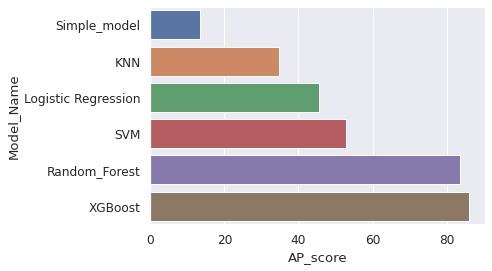

In [ ]:
summary= {'Model_Name': ['Simple_model','KNN','Logistic Regression','SVM','Random_Forest','XGBoost'],
          'AP_score':[Simple_ap,Knn_ap,Logistic_ap,Svm_ap,Random_Forest_accuracy_1_ap,XGB_ap]}

summary= pd.DataFrame(summary)
display(summary)
print('\n\n')
sns.barplot(y = 'Model_Name', x = 'AP_score', data= summary, order=summary.sort_values('AP_score').Model_Name)

fig.set_size_inches(20, 20)
plt.show()

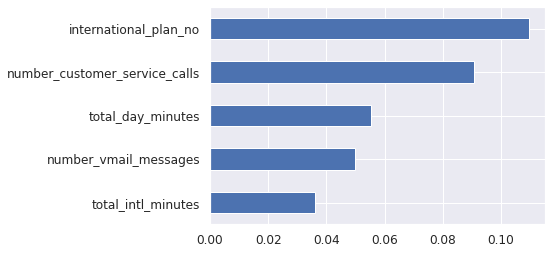

In [ ]:
# Model Importance
from xgboost import plot_importance
final_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.06, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.457506352813779,
              seed=None, silent=None, subsample=1, verbosity=1)

final_model.fit(X_train, y_train)
importances = pd.Series(final_model.feature_importances_, index = features.columns)
importances.nlargest(5).plot(kind='barh').invert_yaxis()

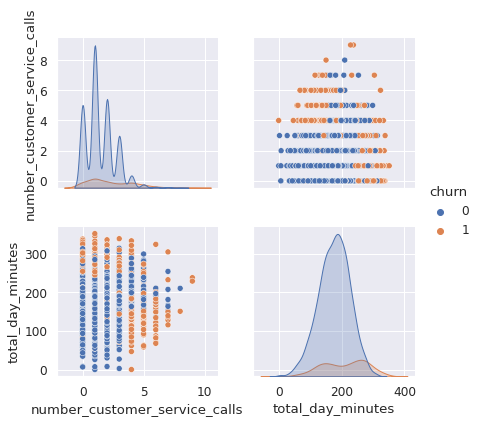

In [ ]:
# importance plot is consistent with the train dataset result.
f = sns.pairplot(train.reset_index()[['churn','number_customer_service_calls','total_day_minutes']], hue="churn",size = 3)

In [ ]:
test_predict = final_model.predict(test)
label = ["no","yes"]
for i in range(len(test_predict)):
  print(label[test_predict[i]])

no
no
yes
yes
yes
no
no
no
no
yes
yes
yes
no
yes
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
yes
no
yes
no
no
no
no
no
no
no
no
no
no
yes
no
no
no
yes
no
no
no
yes
no
no
no
yes
no
no
no
yes
no
no
no
no
no
yes
no
no
no
no
no
no
no
yes
yes
no
no
no
no
no
no
no
no
no
yes
no
yes
no
no
no
no
no
yes
no
no
no
no
yes
yes
no
no
yes
no
yes
no
no
no
no
no
no
no
no
yes
no
yes
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
yes
no
yes
no
no
no
no
no
yes
no
no
no
no
no
no
no
no
yes
no
no
no
no
no
no
no
no
no
no
no
no
no
yes
no
no
no
yes
no
no
no
no
no
no
yes
no
no
yes
no
no
yes
no
no
no
no
no
no
yes
no
yes
yes
yes
no
yes
yes
no
no
no
no
no
no
no
no
yes
yes
no
no
no
no
no
yes
no
no
no
no
no
no
no
yes
yes
no
no
no
yes
no
no
no
no
no
no
no
no
yes
yes
no
no
no
no
no
no
yes
no
no
no
yes
no
no
no
no
no
no
yes
no
no
no
no
yes
no
no
yes
yes
no
no
no
yes
no
yes
no
no
yes
no
no
no
no
no
no
no
no
no
no
no
no
yes
no
no
no
no
no
no
no
yes
no
no
yes
no
no
yes
no
yes
no
no
no
no
n